In [289]:
import pandas as pd
import itertools as it
import numpy as np
from matplotlib import pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm
from sklearn.metrics import mean_squared_error
import math
from scipy import stats
from patsy import dmatrix, dmatrices
import os

## Marco teorico

La contaminación en Colombia se produce principalmente por dos causas, la primera se relaciona con la producción y tratamiento de combustibles fósiles para el sostenimiento de diferentes industrias y la segunda con el consumo de energía. 														     

Según el ministerio de ambiente y desarrollo, Colombia emite el 0.37% de los gases de efecto invernadero en el mundo. Posicionando al país en el puesto 137 en el ranking de países emisores de CO2 entre 184 países evaluados.														

El aumento de la temperatura planetaria provocada por los gases de efecto invernadero y la tala de bosques genera múltiples perjuicios a la humanidad: desórdenes del clima, tormentas tropicales, sequías, aumento y del nivel de los mares a causa del deshielo de los glaciares.																					   									
Colombia, más que por producir CO2, contribuye al calentamiento global con su enorme deforestación que provoca una serie de consecuencias catastróficas para toda la diversidad de nuestros bosque.

La NASA estima que el gradual aumento de las temperaturas que se registrará en el planeta en el transcurso de las próximas décadas provocará una serie de cambios significativos en el ecosistema, que, probablemete, se incrementen con el tiempo.

La temperatura promedio de la Tierra subió 2 grados Fahrenheit a lo largo del siglo XX y el fenómeno sigue manteniendo esa tendencia. Por eso, a futuro se preven incendios forestales más frecuentes, períodos de sequía más prolongados en algunas regiones y tormentas tropicales más intensas, numerosas y duraderas.

## Lectura y limpieza

In [237]:
temperaturas = pd.read_csv('data/temperaturasCol.csv', skiprows=2) # Lectura de bd.
temperaturas.head() # Encabezado de bd.

,Unnamed: 0,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,1901,24.84,25.01,25.30,25.06,24.55,23.90,23.94,24.17,24.23,24.27,24.33,24.34
1,1902,24.54,24.83,24.92,24.78,24.36,23.88,23.76,24.17,24.18,24.30,24.55,24.46
2,1903,24.54,25.00,25.01,24.75,24.37,23.91,23.94,24.17,24.42,24.28,24.35,24.29
3,1904,24.45,25.03,24.87,24.92,24.22,24.08,23.93,24.17,24.42,24.22,24.45,24.32
4,1905,24.43,24.69,24.83,24.79,24.19,23.84,23.94,24.17,24.42,24.34,24.45,24.25


In [238]:
# Nombres de columnas
nuevas_columnas = list(temperaturas.columns) 
# Nombramiento primera columna
nuevas_columnas[0] = "Year" 
# Renombramiento de columnas
temperaturas.columns = nuevas_columnas 

In [239]:
# Pasar datos de anchos a largos
temperaturas = temperaturas.melt(id_vars="Year") 
# Construcción de variable de fecha
temperaturas['date'] = temperaturas[['Year', 'variable']].apply(
    lambda x: str(x['Year']) + '-' + x['variable'],axis=1)
# Formato a la columna de fecha
temperaturas['date'] = pd.to_datetime(temperaturas['date'])

In [240]:
# Ordenar filas por fecha
temperaturas.sort_values(by = 'date', inplace = True) 
# Seleccion de columnas a usar
temperaturas = temperaturas[['date', 'value']] 
# Seleccion de filas desde 1980
temperaturas = temperaturas[temperaturas['date'] >= '1980-01-01']

In [257]:
# Divison serie entrenamiento y prueba
train = temperaturas[(temperaturas['date'] >= '1980-01-01') & (temperaturas['date'] < '2021-01-01')]
test = temperaturas[temperaturas['date'] >= '2021-01-01']
# Pasar fechas a indices
train.set_index('date', inplace = True) 
test.set_index('date', inplace = True)

In [242]:
train

,value
date,
1980-01-01,25.00
1980-02-01,25.39
1980-03-01,25.70
1980-04-01,25.55
1980-05-01,25.12
...,...
2020-08-01,24.86
2020-09-01,24.92
2020-10-01,25.20


In [258]:
test

,value
date,
2021-01-01,25.07
2021-02-01,25.49
2021-03-01,24.93
2021-04-01,25.32
2021-05-01,25.10
2021-06-01,24.42
2021-07-01,24.49
2021-08-01,24.54
2021-09-01,24.88


## Selección de modelo



### Análisis descriptivo

Text(0, 0.5, 'Temperatura °C')

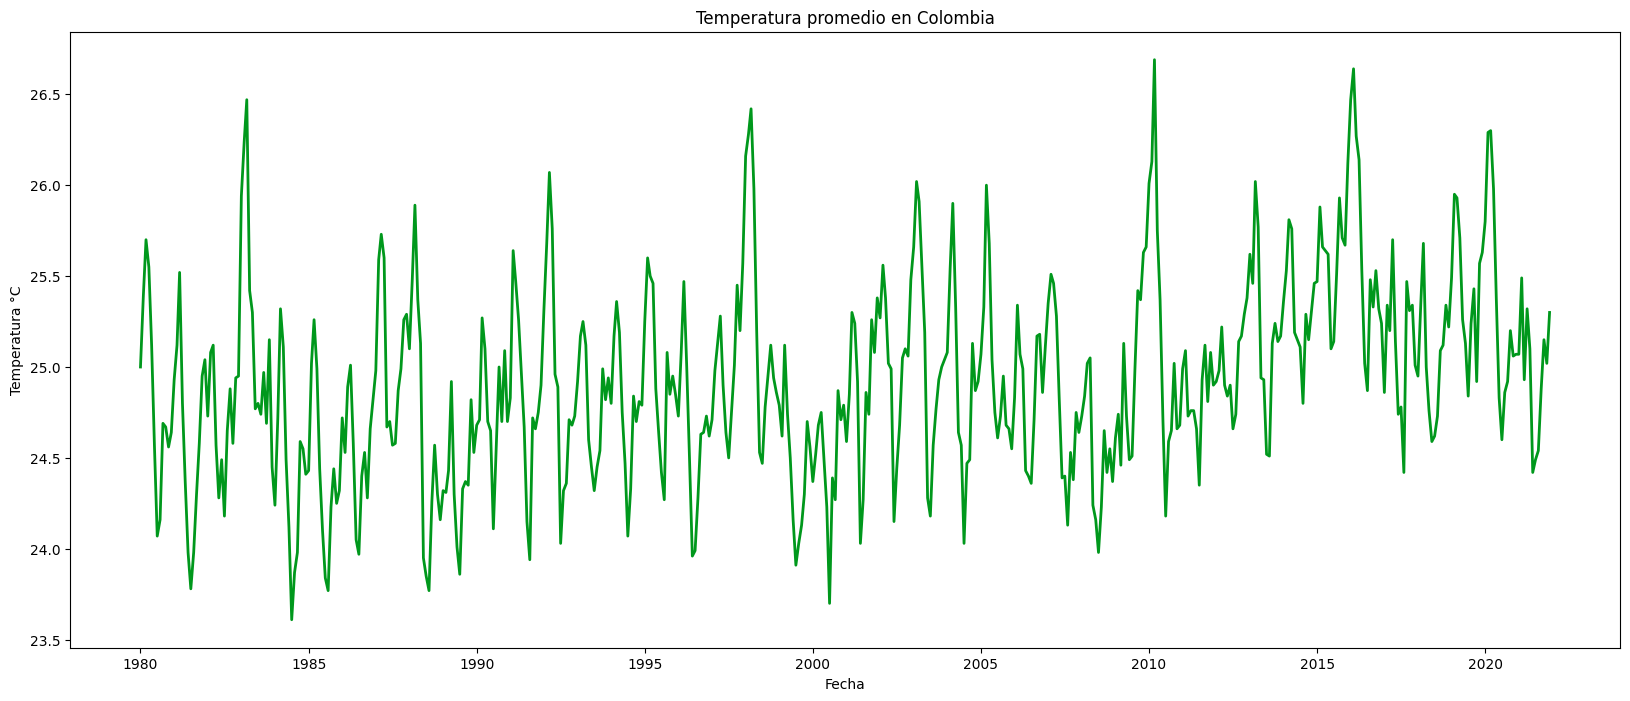

In [302]:
# Grafico serie de tiempo.
plt.figure(figsize = (20,8))
plt.plot(temperaturas['date'], temperaturas['value'], color='#00981C', lw=2)
plt.title('Temperatura promedio en Colombia')
plt.xlabel('Fecha')
plt.ylabel('Temperatura °C')

In [245]:
# Test de Dickey Fuller.
adfuller(train)

(-4.4493905241735465,
 0.0002424633528161175,
 16,
 475,
 {'1%': -3.4441920863262863,
  '5%': -2.8676439813617147,
  '10%': -2.570021186703601},
 136.24944595346722)

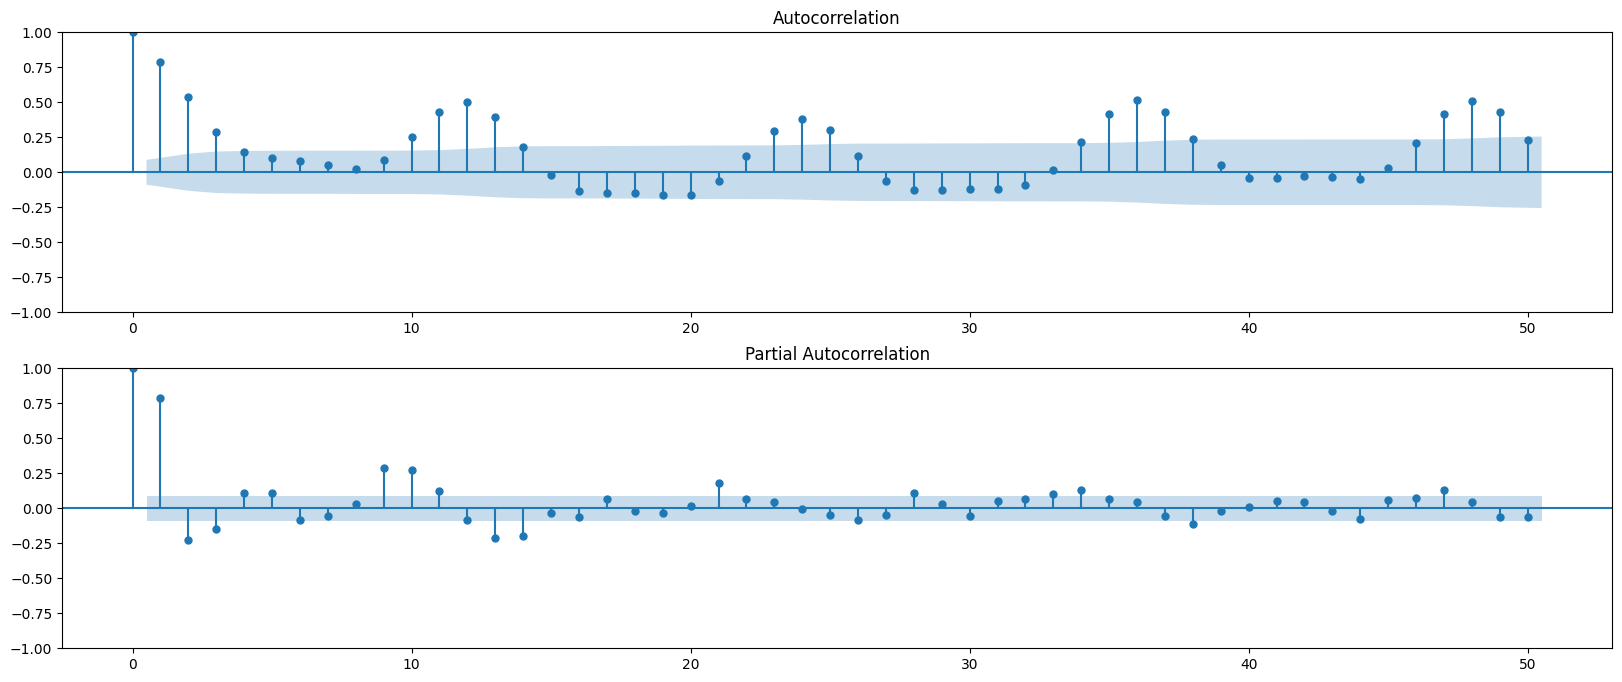

In [303]:
figure, axis = plt.subplots(2,1)
figure.set_size_inches(20,8)

# Graficos de ACF y PACF.
plot_acf(train, ax=axis[0], lags=50);
plot_pacf(train, ax=axis[1], method = 'ywm', lags=50);

- Según el test de Dickey Fuller, para la serie original no es necesario aplicar una diferencia, por lo tanto $d = 0$.
- Se presenta un decaimiento exponencial muy lento en los lags $12, 24, 36, ...$. Esto indica que es necesario tomar una diferencia estacional, luego $D = 1$.
- Además, se puede ver en la ACF que la serie presenta una estacionalidad en periodos de 12 meses, $s = 12$.

In [247]:
# Serie diferenciada anualmente
train12 = train.diff(12).dropna() 

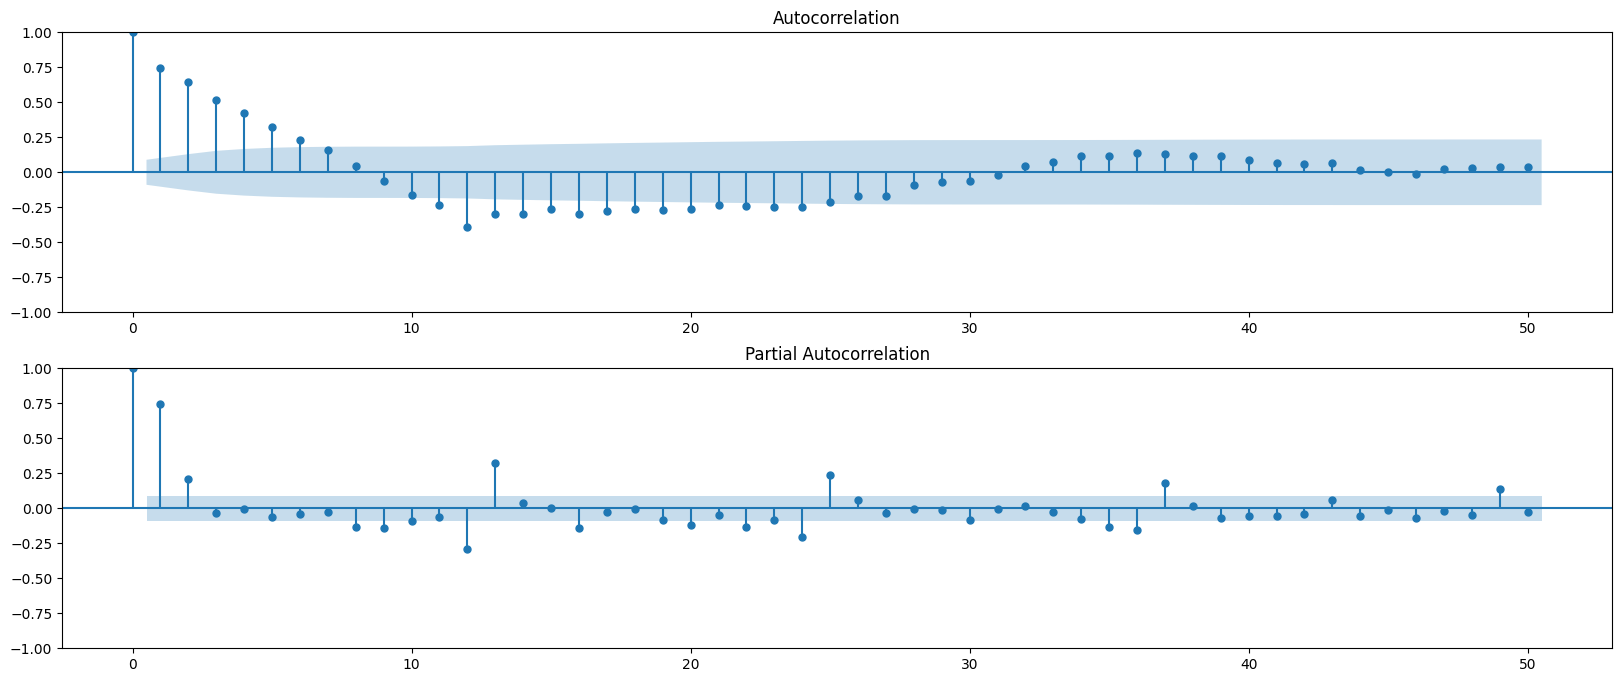

In [304]:
figure, axis = plt.subplots(2,1)
figure.set_size_inches(20,8)

# Graficos de ACF y PACF para serie diferenciada anualmente.
plot_acf(train12, ax=axis[0], lags=50);
plot_pacf(train12, ax=axis[1], method = 'ywm', lags=50);

El comportamiento de la serie diferenciada en el orden 12 no evidencia claramente los ordenes de los parámetros $p, d, P$ y $Q$. Se plantean diferentes modelos y se comparan teniendo en cuento el AIC y BIC para seleccionar el "más" adecuado. 

## Ajuste de modelo

In [ ]:
# Valores en los cuales varian p, q, P y Q
array = np.array([0, 1, 2]) 
# Combinaciones posibles de p, q, P y Q
comb = list(it.product(array, repeat = 4)) 

aic = []; bic = [] # Listas vacias para agregar los AIC y BIC de los modelos.
for i in range(0, len(comb)):
    mod = SARIMAX(train, # Modelo ajustado.
        order=(comb[i][0], 0, comb[i][1]), 
        seasonal_order=(comb[i][2], 1, comb[i][3], 12)).fit()
    aic.append(mod.aic) 
    bic.append(mod.bic)

resumen = pd.DataFrame(data = {'(p,q,P,Q)' : comb, 'AIC' : aic, 'BIC' : bic}) # bd resumen.

In [250]:
# bd ordenada por AIC
resumen.sort_values(by = 'AIC') 

,"(p,q,P,Q)",AIC,BIC
61,"(2, 0, 2, 1)",48.113323,73.156040
43,"(1, 1, 2, 1)",49.147578,74.190295
70,"(2, 1, 2, 1)",49.736431,78.952933
52,"(1, 2, 2, 1)",49.974224,79.190727
62,"(2, 0, 2, 2)",50.103376,79.319879
...,...,...,...
4,"(0, 0, 1, 1)",507.593520,520.114879
9,"(0, 1, 0, 0)",547.728509,556.076081
6,"(0, 0, 2, 0)",552.573444,565.094802
3,"(0, 0, 1, 0)",673.435682,681.783254


In [251]:
# bd ordenada por BIC
resumen.sort_values(by = 'BIC') 

,"(p,q,P,Q)",AIC,BIC
55,"(2, 0, 0, 1)",50.942908,67.638053
37,"(1, 1, 0, 1)",52.124959,68.820104
56,"(2, 0, 0, 2)",52.139660,73.008591
61,"(2, 0, 2, 1)",48.113323,73.156040
58,"(2, 0, 1, 1)",52.328999,73.197929
...,...,...,...
4,"(0, 0, 1, 1)",507.593520,520.114879
9,"(0, 1, 0, 0)",547.728509,556.076081
6,"(0, 0, 2, 0)",552.573444,565.094802
3,"(0, 0, 1, 0)",673.435682,681.783254


In [252]:
# Modelo por auto_arima.
pm.auto_arima(train, start_p=2, d=None, start_q=2, max_p=5, 
    max_d=2, max_q=5, start_P=1, D=None, start_Q=1, max_P=2,
    max_D=1, max_Q=2, max_order=5, m=12, seasonal=True, stationary=False)

ARIMA(order=(2, 1, 2), scoring_args={}, seasonal_order=(1, 0, 1, 12),
      suppress_warnings=True)

Dado lo anterior, se propone ajustar los siguientes modelos:
- Según el mejor AIC: $ARIMA(2,0,0)(2,1,1)[12]$, con $AIC = 48.113$ y $BIC = 73.156$. 
- Según el mejor BIC: $ARIMA(2,0,0)(0,1,1)[12]$, con $AIC = 50.943$ y $BIC = 67.638$.
- Según auto.arima: $ARIMA(2,1,2)(1,0,1)[12]$, con $AIC = 79.759$ y $BIC = 113.331$.

In [ ]:
# Ajuste de modelos seleccionados.
modeloAIC = SARIMAX(train, order=(2, 0, 0), seasonal_order=(2, 1, 1, 12)).fit()
modeloBIC = SARIMAX(train, order=(2, 0, 0), seasonal_order=(0, 1, 1, 12)).fit()
modeloAA = SARIMAX(train, order=(2, 1, 2), seasonal_order=(1, 0, 1, 12)).fit()

In [225]:
modeloAIC.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                value   No. Observations:                  492
Model:             SARIMAX(2, 0, 0)x(2, 1, [1], 12)   Log Likelihood                 -18.057
Date:                              Wed, 16 Nov 2022   AIC                             48.113
Time:                                      00:22:25   BIC                             73.156
Sample:                                  01-01-1980   HQIC                            57.957
                                       - 12-01-2020                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5741      0.042     13.730      0.000       0.492       0.656
ar.L2          0.2623      0.045      5.842      0.000       0.174       0.350
ar.S.L12      -0.0711      0.051     -1.408      0.159      -0.170       0.028
ar.S.L24      -0.1277      0.051     -2.481      0.013      -0.229      -0.027
ma.S.L12      -0.9047      0.033    -27.682      0.000      -0.969      -0.841
sigma2         0.0599      0.004     15.017      0.000       0.052       0.068
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):                 0.46
Prob(Q):                              0.77   Prob(JB):                         0.79
Heteroskedasticity (H):               1.01   Skew:                            -0.06
Prob(H) (two-sided):                  0.94   Kurtosis:                         3.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [226]:
modeloBIC.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                value   No. Observations:                  492
Model:             SARIMAX(2, 0, 0)x(0, 1, [1], 12)   Log Likelihood                 -21.471
Date:                              Wed, 16 Nov 2022   AIC                             50.943
Time:                                      00:22:32   BIC                             67.638
Sample:                                  01-01-1980   HQIC                            57.505
                                       - 12-01-2020                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5920      0.041     14.346      0.000       0.511       0.673
ar.L2          0.2500      0.045      5.599      0.000       0.162       0.337
ma.S.L12      -0.9448      0.029    -32.977      0.000      -1.001      -0.889
sigma2         0.0605      0.004     15.378      0.000       0.053       0.068
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                 0.10
Prob(Q):                              0.82   Prob(JB):                         0.95
Heteroskedasticity (H):               1.00   Skew:                            -0.03
Prob(H) (two-sided):                  0.98   Kurtosis:                         3.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [227]:
modeloAA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                value   No. Observations:                  492
Model:             SARIMAX(2, 1, 2)x(1, 0, [1], 12)   Log Likelihood                 -21.854
Date:                              Wed, 16 Nov 2022   AIC                             57.707
Time:                                      00:22:37   BIC                             87.082
Sample:                                  01-01-1980   HQIC                            69.243
                                       - 12-01-2020                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4458      0.036     12.473      0.000       0.376       0.516
ar.L2          0.3195      0.032      9.954      0.000       0.257       0.382
ma.L1         -0.8427      0.031    -27.191      0.000      -0.903      -0.782
ma.L2         -0.1499      0.020     -7.572      0.000      -0.189      -0.111
ar.S.L12       0.9988      0.001    696.040      0.000       0.996       1.002
ma.S.L12      -0.9442      0.032    -29.435      0.000      -1.007      -0.881
sigma2         0.0601      0.004     15.292      0.000       0.052       0.068
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                 0.12
Prob(Q):                              0.84   Prob(JB):                         0.94
Heteroskedasticity (H):               0.95   Skew:                            -0.02
Prob(H) (two-sided):                  0.75   Kurtosis:                         3.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

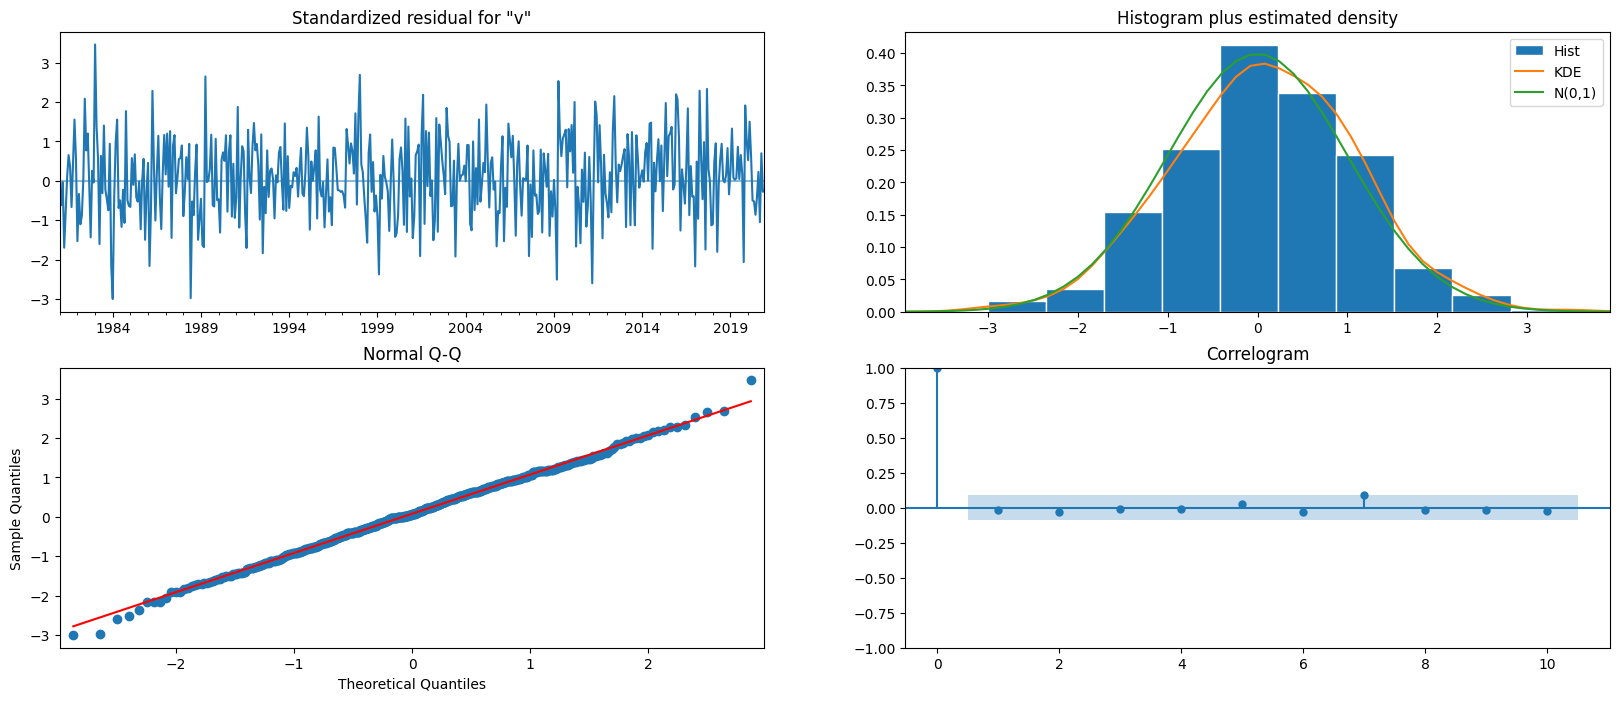

In [305]:
modeloAIC.plot_diagnostics(figsize=(20, 8))
plt.show()

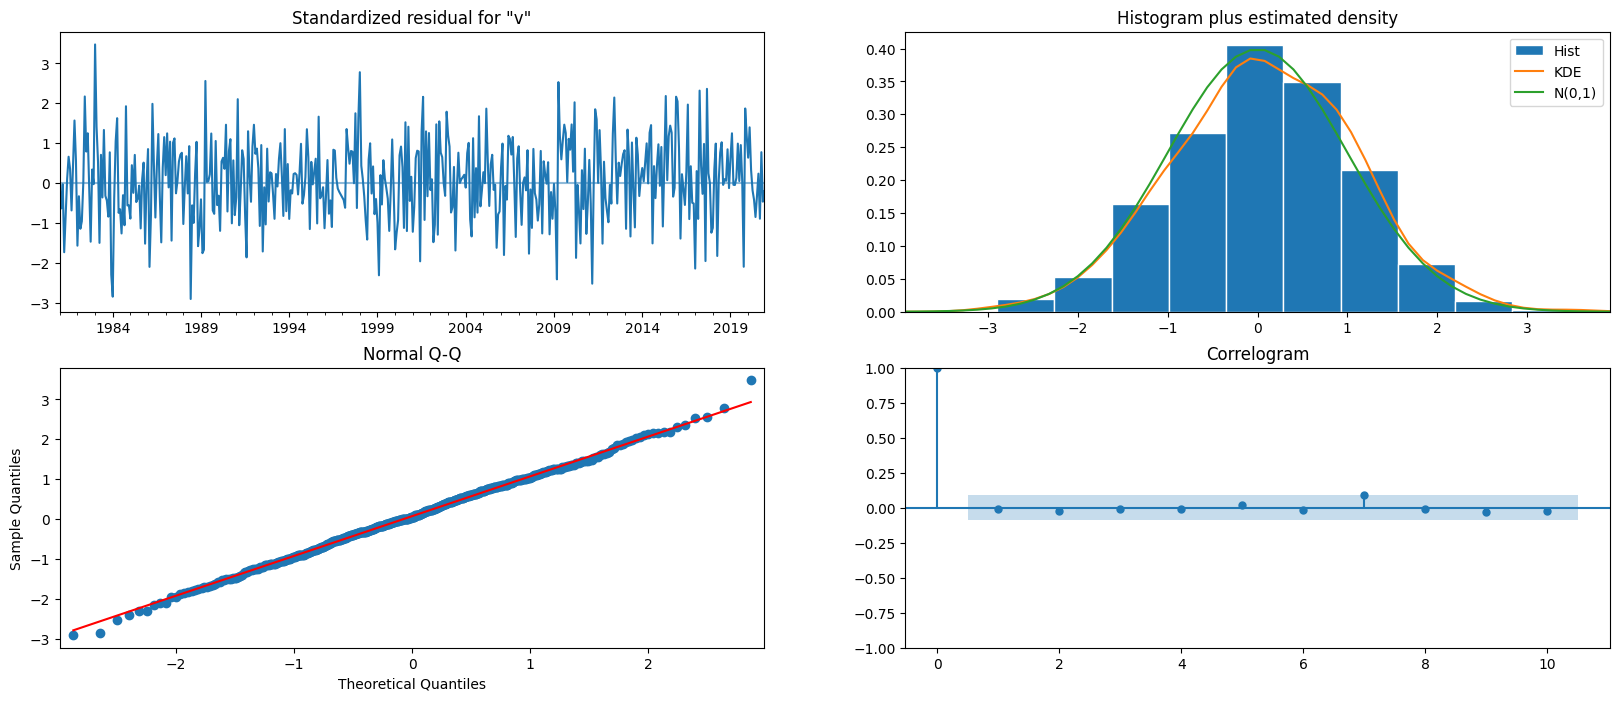

In [306]:
modeloBIC.plot_diagnostics(figsize=(20, 8))
plt.show()

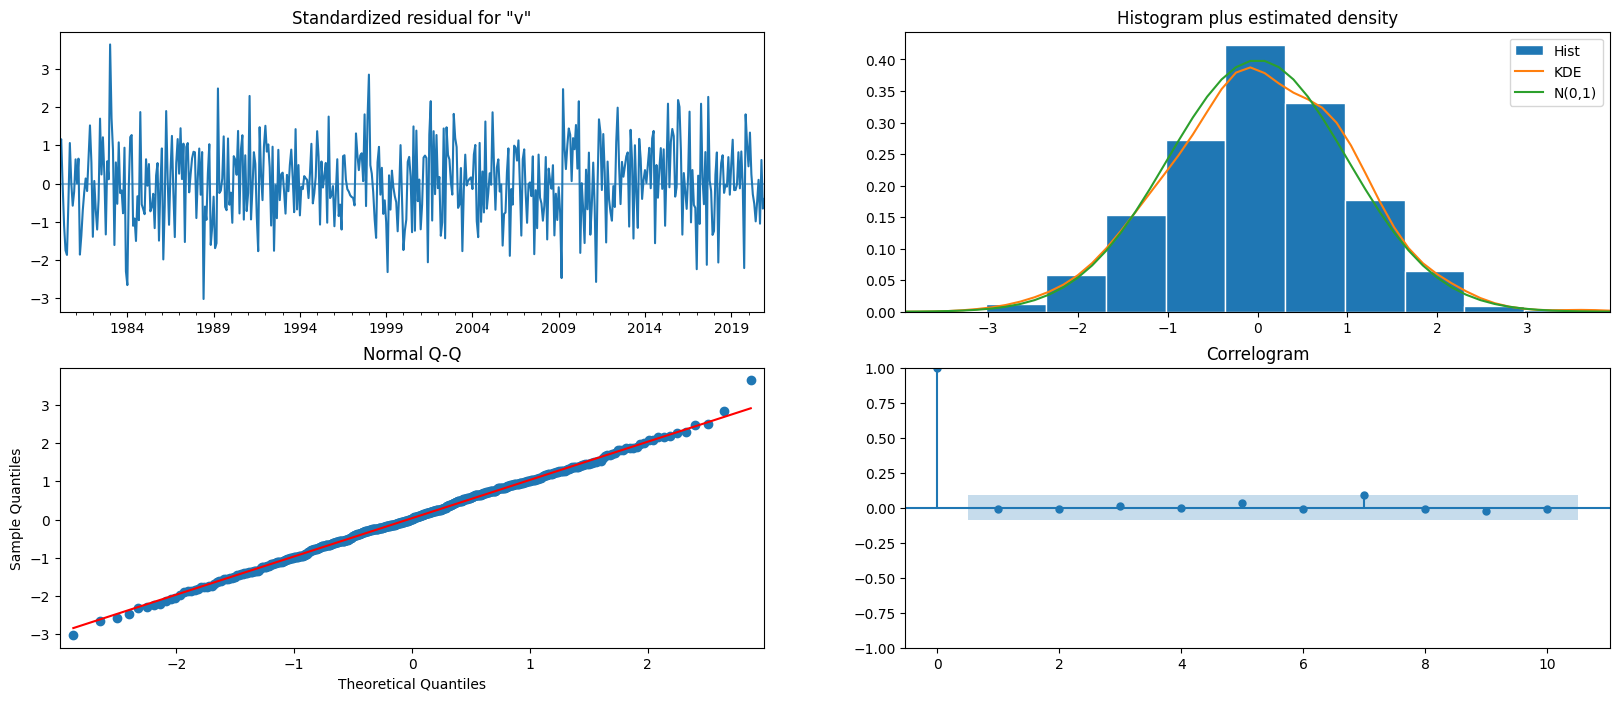

In [307]:
modeloAA.plot_diagnostics(figsize=(20, 8))
plt.show()

## Realización y validación de predicciones

In [281]:
predict_AIC = modeloAIC.forecast(steps=12, exog=test)
predict_BIC = modeloBIC.forecast(steps=12, exog=test)
predict_AA = modeloAA.forecast(steps=12, exog=test)

<AxesSubplot: title={'center': 'Predicciones'}, xlabel='fecha', ylabel='Temperatura °C'>

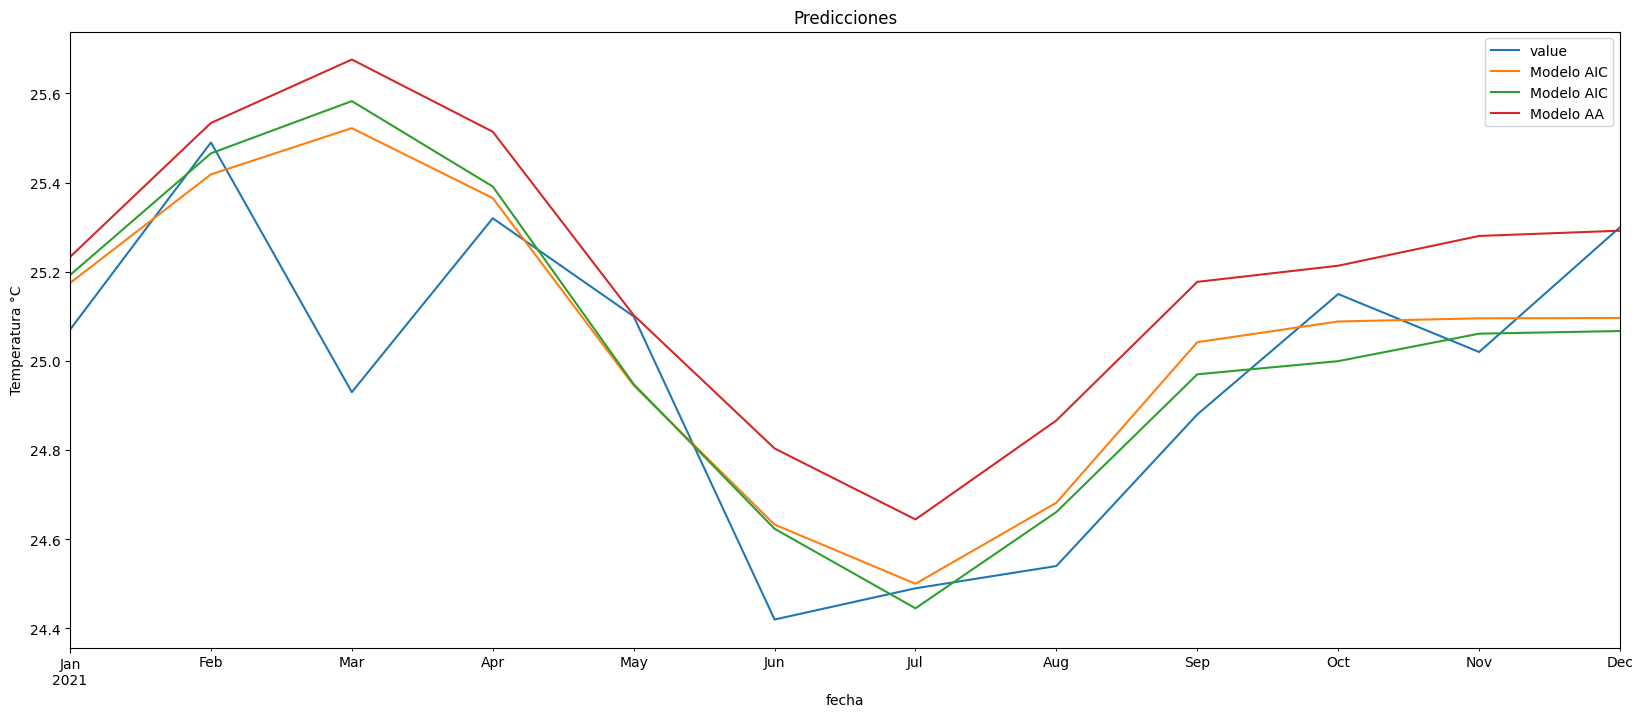

In [308]:
test.plot(xlabel = 'fecha', ylabel = 'Temperatura °C', title = 'Predicciones', figsize = (20,8))
predict_AIC.plot(legend = True, label = 'Modelo AIC')
predict_BIC.plot(legend = True, label = 'Modelo AIC')
predict_AA.plot(legend = True, label = 'Modelo AA')

In [290]:
def mse (actual, pred):
    MSE = mean_squared_error(actual.values, pred.values)
    return math.sqrt(MSE)

def mape (actual , pred):
    actual, pred = np.array (actual), np.array (pred)
    return np.mean (np.abs ((actual - pred) / actual)) * 100

In [292]:
pd.DataFrame(data = {'Modelo' : ['AIC', 'BIC', 'AA'],
                    'MSE' : [mse(test, predict_AIC), mse(test, predict_BIC), mse(test, predict_AA)],
                    'MAPE' : [mape(test, predict_AIC), mape(test, predict_BIC), mape(test, predict_AA)]})  

,Modelo,MSE,MAPE
0,AIC,0.211283,1.454714
1,BIC,0.226334,1.517128
2,AA,0.297314,1.595351


## Conclusiones y recomendaciones

* Se recomienda probar otro tipo de modelos como LOESS y splines.